##Load The Data

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [ ]:
#import the data
start_date = "2024-08-23"
end_date = "2025-08-23"
hist = yf.Ticker('^GSPC')
df= hist.history(start=start_date, end=end_date, auto_adjust=True)
csv_filename = "SP500.csv"
df.to_csv(csv_filename)
print(df.head())

                                  Open         High          Low        Close  \
Date                                                                            
2024-08-23 00:00:00-04:00  5602.490234  5641.819824  5585.160156  5634.609863   
2024-08-26 00:00:00-04:00  5639.660156  5651.620117  5602.339844  5616.839844   
2024-08-27 00:00:00-04:00  5602.890137  5631.180176  5593.479980  5625.799805   
2024-08-28 00:00:00-04:00  5624.509766  5627.029785  5560.950195  5592.180176   
2024-08-29 00:00:00-04:00  5607.299805  5646.950195  5583.709961  5591.959961   

                               Volume  Dividends  Stock Splits  
Date                                                            
2024-08-23 00:00:00-04:00  3291940000        0.0           0.0  
2024-08-26 00:00:00-04:00  2938570000        0.0           0.0  
2024-08-27 00:00:00-04:00  2798990000        0.0           0.0  
2024-08-28 00:00:00-04:00  3053450000        0.0           0.0  
2024-08-29 00:00:00-04:00  3065640000     

In [ ]:
df=df['Close']
df.head(5)

,Close
Date,
2024-08-23 00:00:00-04:00,5634.609863
2024-08-26 00:00:00-04:00,5616.839844
2024-08-27 00:00:00-04:00,5625.799805
2024-08-28 00:00:00-04:00,5592.180176
2024-08-29 00:00:00-04:00,5591.959961


In [ ]:
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.head(5)

,Date,Close
0,2024-08-23,5634.609863
1,2024-08-26,5616.839844
2,2024-08-27,5625.799805
3,2024-08-28,5592.180176
4,2024-08-29,5591.959961


##Plot The Data

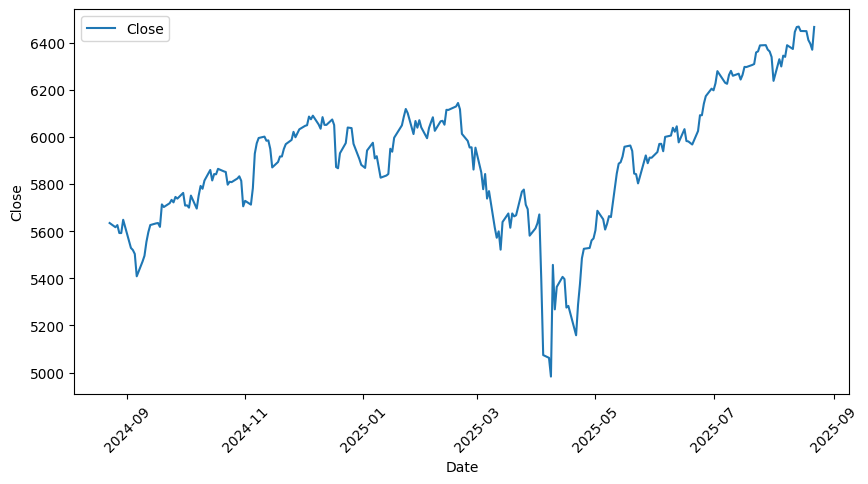

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'],label='Close')

plt.xlabel("Date")
plt.ylabel("Close")
plt.xticks(rotation=45)
plt.legend()
plt.show()

##Split Data Into Data Train & Data Test

In [ ]:
train_size = int(len(df)*0.9)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]
print(len(df_train))
print(len(df_test))

225
25


#Check Stationary with ADF & ACF PACF

In [ ]:
result = adfuller(df_train['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.272341960411051
p-value: 0.6417290206734335


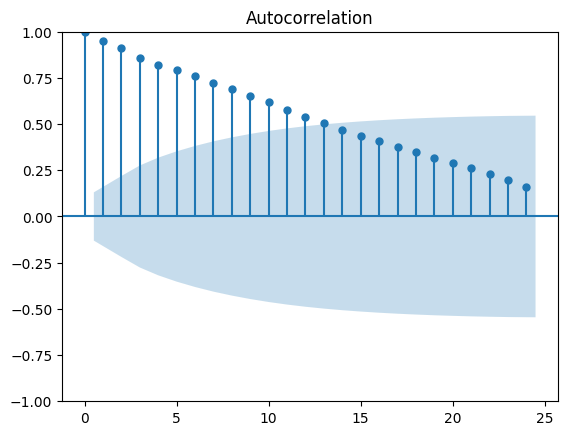

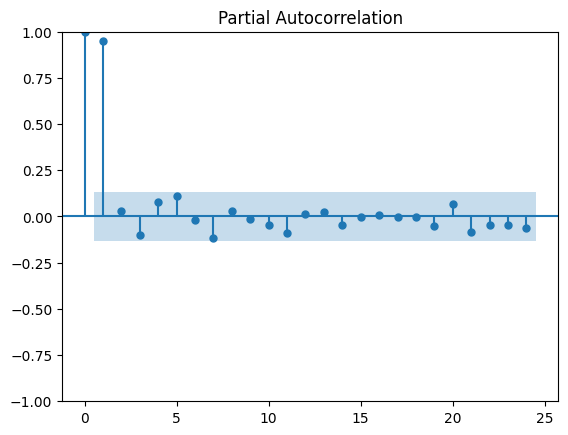

In [ ]:
plot_acf(df_train['Close'])
plot_pacf(df_train['Close'])
plt.show()

##Transform to stationary: Differencing

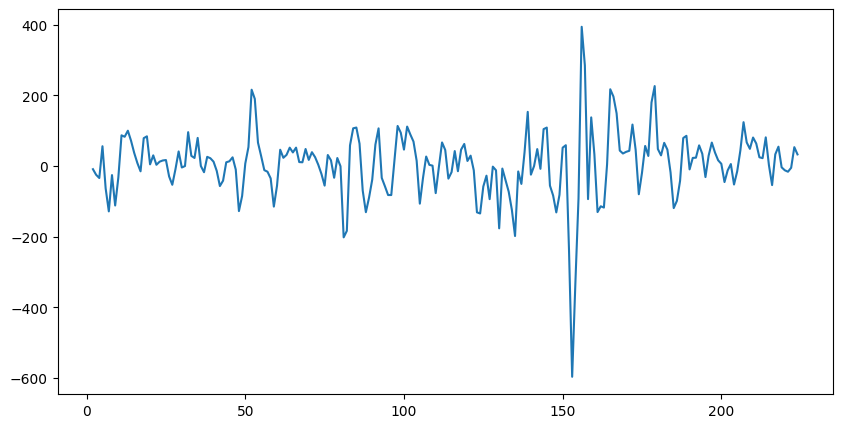

In [ ]:
df_train_diff = df_train['Close'].diff(2).dropna()
plt.figure(figsize=(10,5))
plt.plot(df_train_diff)
plt.show()

In [ ]:
adf_test = adfuller(df_train_diff)
print(f"p-value stlh differencing: {adf_test[1]}")

p-value stlh differencing: 0.0002295337641462979


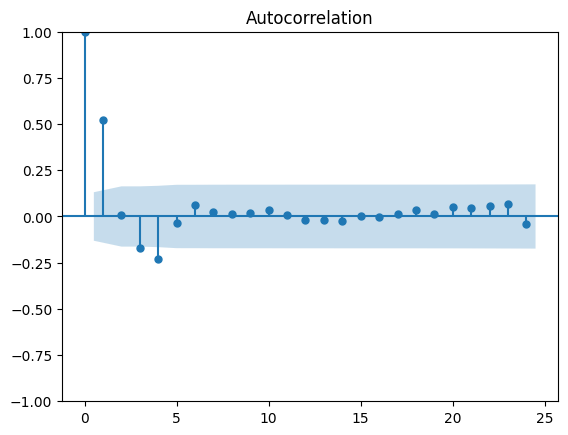

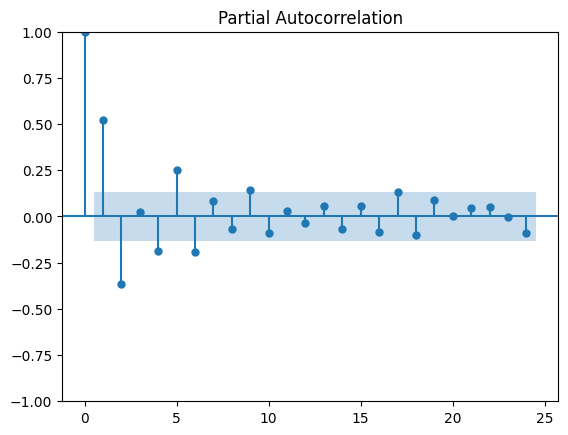

In [ ]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

##ARIMA Model Manual

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model_manual = ARIMA(df_train['Close'], order=(1,2,1))
arima_fit_manual = arima_model_manual.fit()
print(arima_fit_manual.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1261.494
Date:                Sun, 24 Aug 2025   AIC                           2528.988
Time:                        15:18:34   BIC                           2539.209
Sample:                             0   HQIC                          2533.114
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0693      0.039     -1.756      0.079      -0.147       0.008
ma.L1         -0.9993      0.143     -7.013      0.000      -1.279      -0.720
sigma2      4680.0632    740.677      6.319      0.0

##Prediction The Data

In [ ]:
#Predictions for the next 25 periods
forecast_manual = arima_fit_manual.forecast(steps=25)
future_dates_manual = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=25, freq='B')
df_forecast_manual = pd.DataFrame({"Date": future_dates_manual, "Forecast": forecast_manual})
df_forecast_manual.head(10)

,Date,Forecast
225,2025-08-25,6300.125360
226,2025-08-26,6303.190067
227,2025-08-27,6306.273526
228,2025-08-28,6309.355686
229,2025-08-29,6312.437936
230,2025-09-01,6315.520180
231,2025-09-02,6318.602424
232,2025-09-03,6321.684669
233,2025-09-04,6324.766913
234,2025-09-05,6327.849157


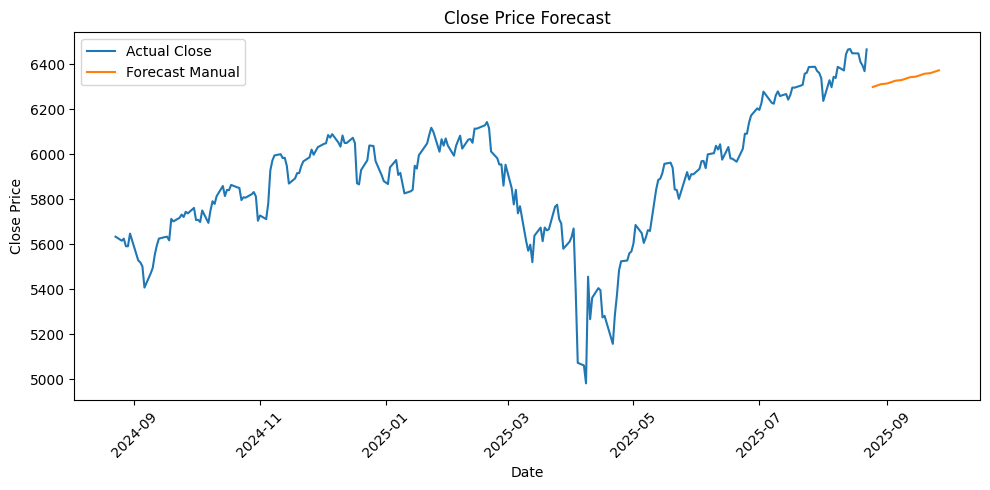

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'], label="Actual Close")
plt.plot(df_forecast_manual['Date'], df_forecast_manual['Forecast'], label="Forecast Manual")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Forecast")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Arima Model Auto

In [ ]:
import pmdarima as pm

In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train['Close'], stepwise=False, seasonal=False)
auto_arima

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

ARIMA(order=(0, 1, 4), scoring_args={}, suppress_warnings=True)

In [ ]:
arima_model_auto = ARIMA(df_train['Close'], order=(0,1,4))
arima_fit_auto = arima_model_auto.fit()
print(arima_fit_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 4)   Log Likelihood               -1256.070
Date:                Sun, 24 Aug 2025   AIC                           2522.141
Time:                        15:19:56   BIC                           2539.199
Sample:                             0   HQIC                          2529.026
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0600      0.041     -1.465      0.143      -0.140       0.020
ma.L2          0.1736      0.065      2.662      0.008       0.046       0.301
ma.L3         -0.1504      0.049     -3.042      0.0

In [ ]:
#Predictions for the next 25 periods
forecast_auto = arima_fit_auto.forecast(steps=25)
future_dates_auto = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=25, freq='B')
df_forecast_auto = pd.DataFrame({"Date": future_dates_auto, "Forecast": forecast_auto})
df_forecast_auto.head(10)

,Date,Forecast
225,2025-08-25,6299.594953
226,2025-08-26,6292.001835
227,2025-08-27,6286.988108
228,2025-08-28,6287.120063
229,2025-08-29,6287.120063
230,2025-09-01,6287.120063
231,2025-09-02,6287.120063
232,2025-09-03,6287.120063
233,2025-09-04,6287.120063
234,2025-09-05,6287.120063


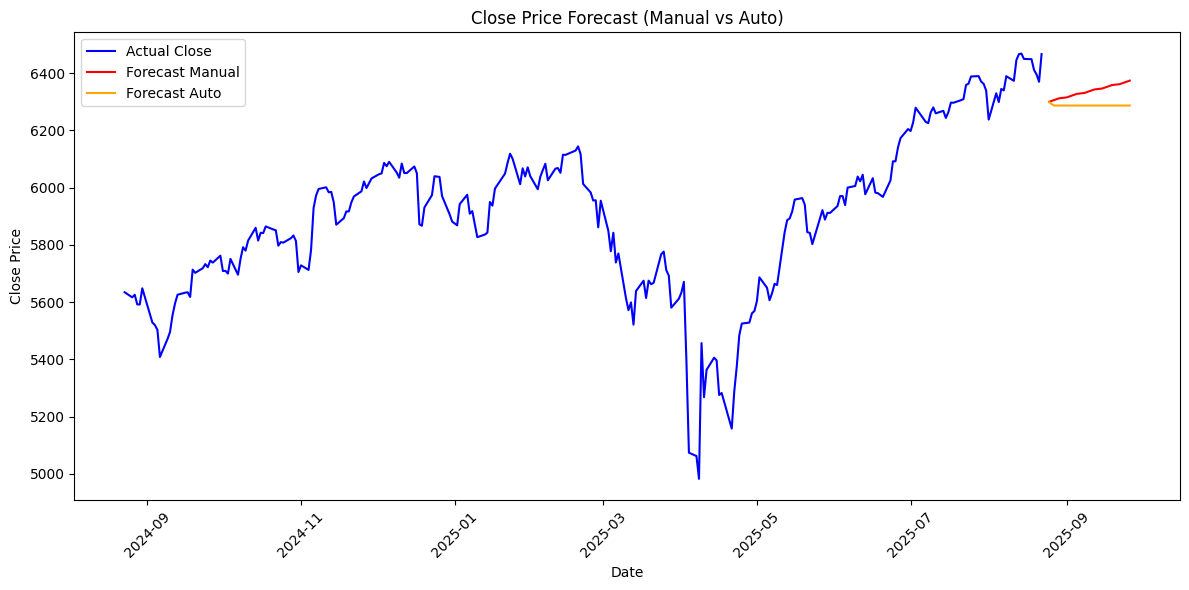

In [ ]:
plt.figure(figsize=(12,6))

# Data aktual
plt.plot(df['Date'], df['Close'], label="Actual Close", color="blue")

# Forecast manual
plt.plot(df_forecast_manual['Date'], df_forecast_manual['Forecast'],
         label="Forecast Manual", color="red")

# Forecast auto
plt.plot(df_forecast_auto['Date'], df_forecast_auto['Forecast'],
         label="Forecast Auto", color="orange")

# Styling
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Forecast (Manual vs Auto)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##MAPE & RMSE

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#ARIMA(1,2,1)
mape_manual = mean_absolute_percentage_error(df_test['Close'], df_forecast_manual['Forecast'])
rmse_manual = np.sqrt(mean_squared_error(df_test['Close'], df_forecast_manual['Forecast']))

print(f'mape - manual: {mape_manual}')
print(f'rmse - manual: {rmse_manual}')

mape - manual: 0.007834553116681483
rmse - manual: 62.12558237364251


In [ ]:
#ARIMA(0,1,4)
mape_auto = mean_absolute_percentage_error(df_test['Close'], df_forecast_auto['Forecast'])
rmse_auto = np.sqrt(mean_squared_error(df_test['Close'], df_forecast_auto['Forecast']))

print(f'mape - auto: {mape_auto}')
print(f'rmse - auto: {rmse_auto}')

mape - auto: 0.014553600154439246
rmse - auto: 106.88315488510214
